In [1]:
import numpy as np
import matplotlib.pyplot as plt
from load_MNIST import MnistDataloader
from os.path import join
import random
import time
import math
%matplotlib inline
np.random.seed(1)

Number of training examples in training set : 60000
Number of training examples in test set : 10000
size of each image : 28*28


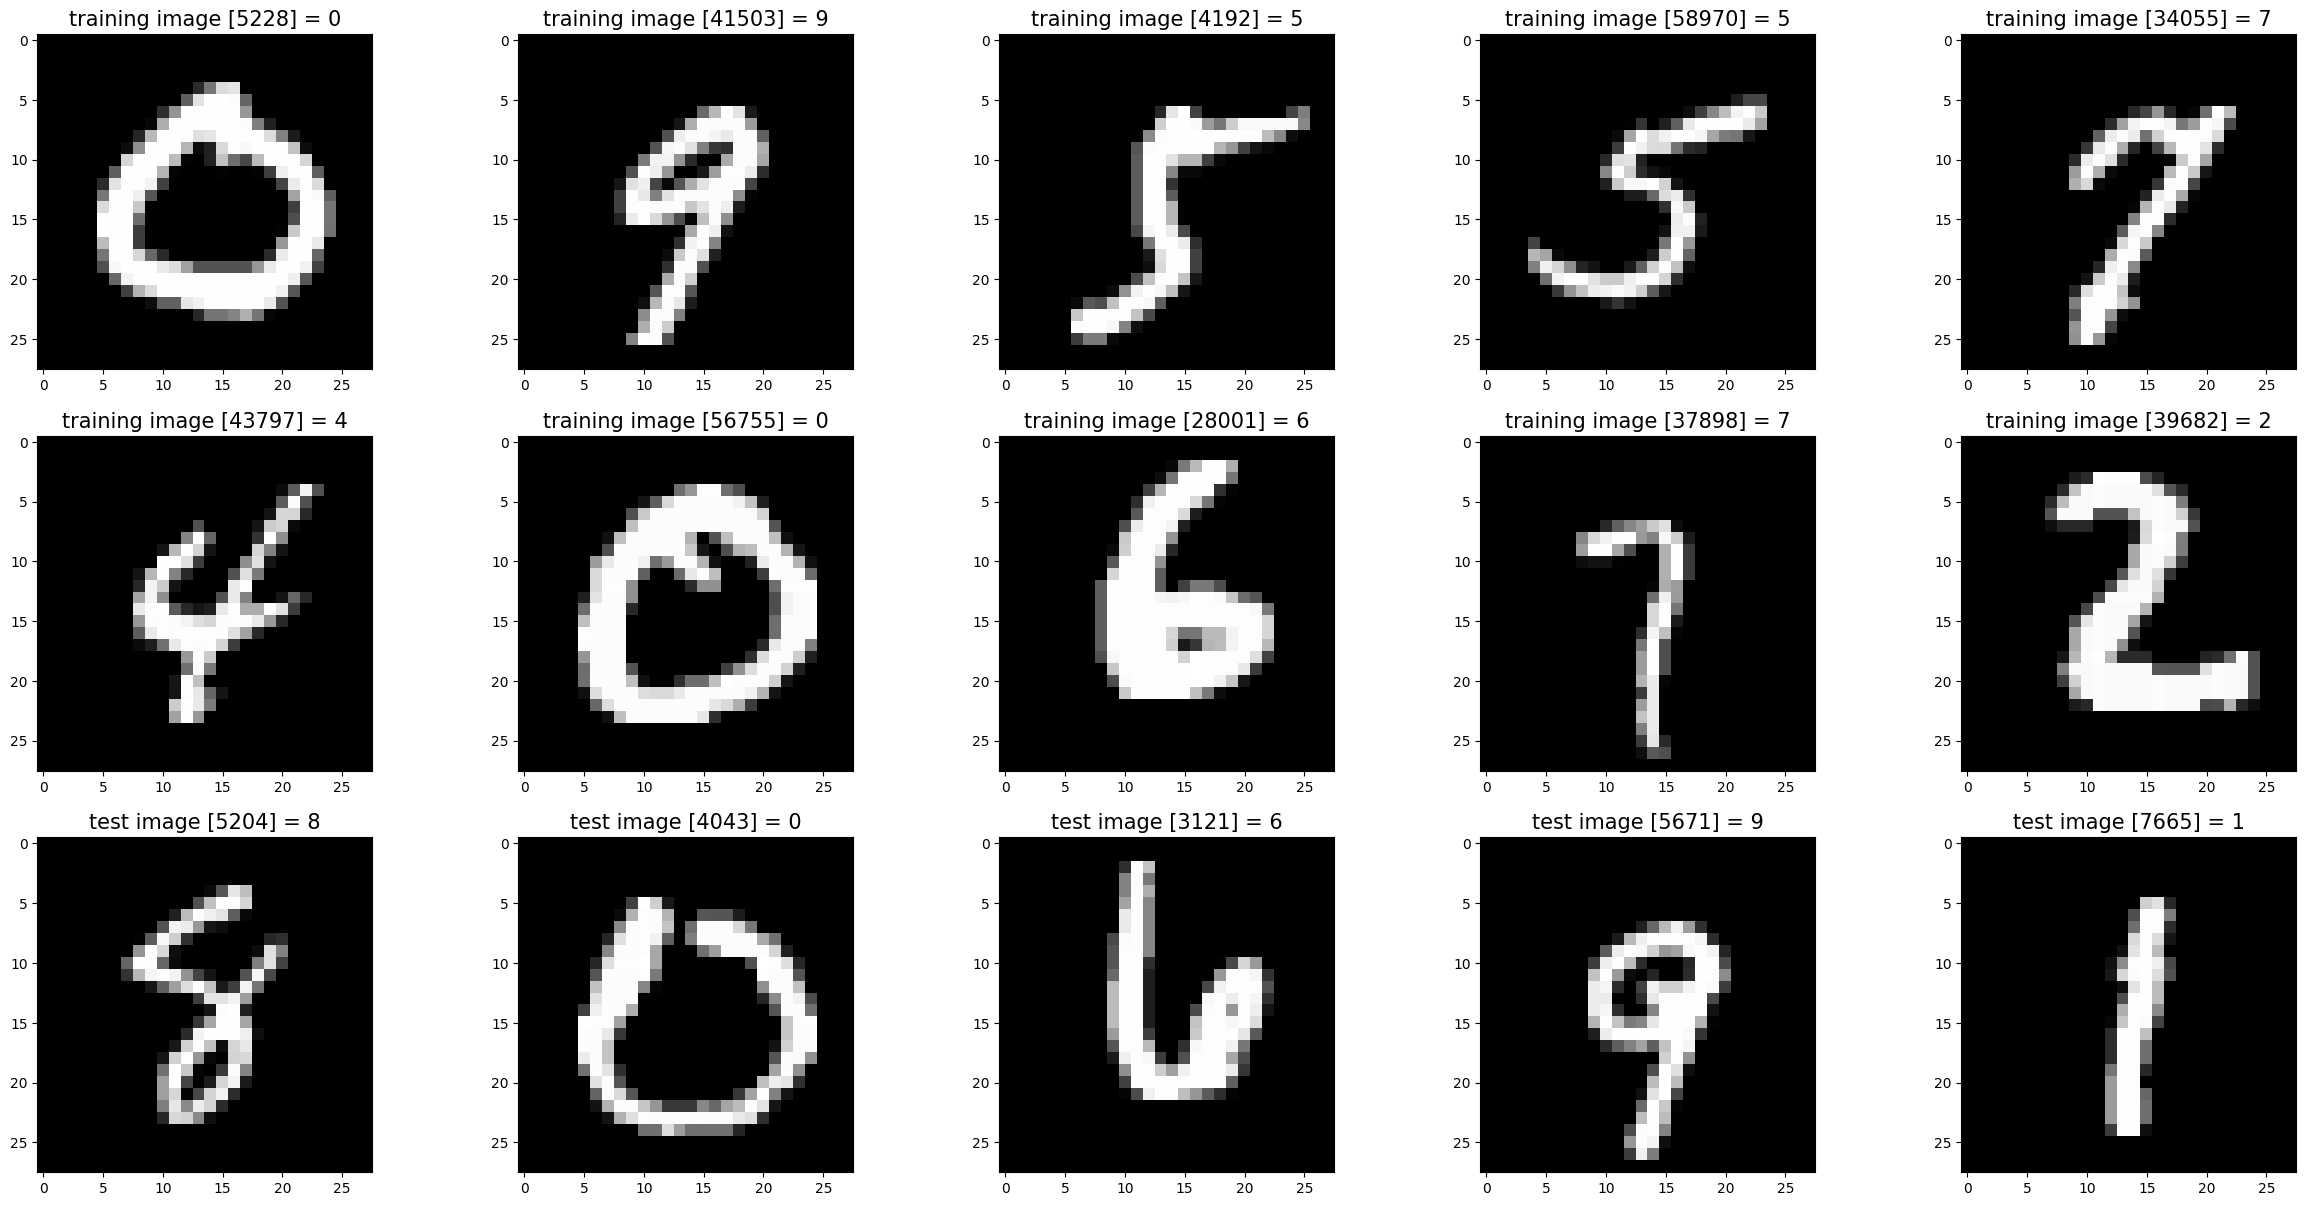

In [2]:
#Loading MNIST dataset
input_path = 'datasets/MNIST_dataset/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

m_train = len(x_train)
m_test = len(x_test)
num_pixel = len(x_train[0])

print(f"Number of training examples in training set : {m_train}")
print(f"Number of training examples in test set : {m_test}")
print(f"size of each image : {num_pixel}*{num_pixel}")

In [3]:
#unrolling the training and testing data
x_train = np.array(x_train).reshape((60000, 28*28)).T / 255.0
x_test = np.array(x_test).reshape((10000, 28*28)).T / 255.0    

y_train = np.array(y_train).reshape((1, 60000))  
y_test = np.array(y_test).reshape((1, 10000))   

In [4]:
def dictionary_to_vector(parameters):
    keys = []
    count = 0
    for key in ["W1", "b1", "W2", "b2", "W3", "b3"]:
        
        # flatten parameter
        new_vector = np.reshape(parameters[key], (-1,1))
        keys = keys + [key]*new_vector.shape[0]
        
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1

    return theta, keys

def vector_to_dictionary(theta):
    parameters = {}
    parameters["W1"] = theta[:19600].reshape((25,784))
    parameters["b1"] = theta[19600:19625].reshape((25,1))
    parameters["W2"] = theta[19625:20000].reshape((15,25))
    parameters["b2"] = theta[20000:20015].reshape((15,1))
    parameters["W3"] = theta[20015:20165].reshape((10,15))
    parameters["b3"] = theta[20165:20175].reshape((10,1))

    return parameters

def gradients_to_vector(gradients):
    count = 0
    for key in ["dW1", "db1", "dW2", "db2", "dW3", "db3"]:
        # flatten parameter
        new_vector = np.reshape(gradients[key], (-1,1))
        
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1

    return theta

In [5]:
def relu(Z):
    return np.maximum(Z,0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def d_relu(Z):
    return Z>0

def one_hot_encoding(Y):
    one_hot_Y = np.zeros((Y.size, Y.max()+1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [6]:
def initialize_parameters(layer_dims):
    L = len(layer_dims)

    parameters = {}
    for l in range(1,L):
        parameters[f"W{l}"] = np.random.randn(layer_dims[l],layer_dims[l-1])*np.sqrt(2/layer_dims[l-1])
        parameters[f"b{l}"] = np.zeros((layer_dims[l],1))

    return parameters

In [7]:
def forward_propogation_layer(W,b,A_prev,activation,keep_prob):

    Z = np.dot(W,A_prev) + b
    if activation == "relu":
        A = relu(Z)
    elif activation == "softmax":
        A = softmax(Z)

    D = np.random.rand(A.shape[0],A.shape[1])
    D = (D < keep_prob).astype(int)
    A = A*D
    A = A/keep_prob

    linear_cache = (W,b,A_prev)
    activation_cache = (Z,)
    dropout_cache = (D,)
    
    return A,(linear_cache, activation_cache,dropout_cache)

In [8]:
def forward_propogation(X,parameters,keep_prob):
    L = len(parameters)//2
    caches = []
    A = X
    
    for l in range(1,L):
        W = parameters[f"W{l}"]
        b = parameters[f"b{l}"]
        A,cache = forward_propogation_layer(W,b,A,"relu",keep_prob)
        caches.append(cache)

    W = parameters[f"W{L}"]
    b = parameters[f"b{L}"]
    AL,cache = forward_propogation_layer(W,b,A,"softmax",1)
    caches.append(cache)
    
    return AL,caches

In [9]:
def compute_cost(Y,AL,parameters,lambd):
    Y = one_hot_encoding(Y)
    m = Y.shape[1]
    L = len(parameters)//2
    regularization_cost = 0
    
    for l in range(1,L+1):
        regularization_cost += (lambd/(2*m))*np.sum(np.square(parameters[f"W{l}"]))
        
    cost = (-np.sum(Y * np.log(AL + 1e-8)) / m) + (regularization_cost)  
    return float(np.squeeze(cost))

In [10]:
def backpropogation_layer(dA,c_cache,activation,m, lambd,keep_prob):
    linear_cache = c_cache[0]
    activation_cache = c_cache[1]
    dropout_cache = c_cache[2]

    grad = {}
    
    W = linear_cache[0]
    b = linear_cache[1]
    A_prev = linear_cache[2]
    
    Z = activation_cache[0]

    D = dropout_cache[0]

    dA = dA*D
    dA = dA/keep_prob
    
    if activation == "relu":
        dZ = dA*d_relu(Z)
    if activation == "softmax":
        dZ = dA
    dW = np.dot(dZ,A_prev.T)/m + (lambd/m)*W
    db = np.sum(dZ, axis=1, keepdims = True)/m
    dA = np.dot(W.T,dZ)    

    grad["dW"] = dW
    grad["db"] = db

    return dA,grad

In [11]:
def backpropogation(AL, caches,Y,lambd,keep_prob):
    L = len(caches)
    m = Y.shape[1]
    grads = {}
    one_hot_Y = one_hot_encoding(Y)
    dA = AL - one_hot_Y
    c_cache = caches[L-1]
    dA, grad = backpropogation_layer(dA,c_cache,"softmax",m,lambd,1)

    grads[f"dW{L}"] = grad["dW"]
    grads[f"db{L}"] = grad["db"]
    
    for l in range(L-2,-1,-1):
        c_cache = caches[l]
        dA, grad = backpropogation_layer(dA,c_cache,"relu",m,lambd,keep_prob)

        grads[f"dW{l + 1}"] = grad["dW"]
        grads[f"db{l + 1}"] = grad["db"]

    return grads
        

In [12]:
def update_parameters(grads, parameters, learning_rate):
    L = len(parameters)//2

    for l in range(1,L+1):
        W = parameters[f"W{l}"]
        b = parameters[f"b{l}"]

        dW = grads[f"dW{l}"]
        db = grads[f"db{l}"]

        W = W - learning_rate*dW
        b = b - learning_rate*db

        parameters[f"W{l}"] = W
        parameters[f"b{l}"] = b

    return parameters

In [13]:
def adam_optimizer(grads,parameters,v,s,learning_rate, beta_1, beta_2,t, epsilon=1e-8):
    L = len(parameters)//2

    v_corrected = {}
    s_corrected = {}

    for l in range(1,L+1):
        v[f"dW{l}"] = v[f"dW{l}"]*beta_1 + (1-beta_1)*grads[f"dW{l}"]
        v[f"db{l}"] = v[f"db{l}"]*beta_1 + (1-beta_1)*grads[f"db{l}"]

        v_corrected[f"dW{l}"] = v[f"dW{l}"]/(1-beta_1**t)
        v_corrected[f"db{l}"] = v[f"db{l}"]/(1-beta_1**t)

        s[f"dW{l}"] = s[f"dW{l}"]*beta_2 + (1-beta_2)*np.square(grads[f"dW{l}"])
        s[f"db{l}"] = s[f"db{l}"]*beta_2 + (1-beta_2)*np.square(grads[f"db{l}"])

        s_corrected[f"dW{l}"] = s[f"dW{l}"]/(1-beta_2**t)
        s_corrected[f"db{l}"] = s[f"db{l}"]/(1-beta_2**t)

        parameters[f"W{l}"] = parameters[f"W{l}"] - learning_rate*(v_corrected[f"dW{l}"]/(np.sqrt(s_corrected[f"dW{l}"]) + epsilon))
        parameters[f"b{l}"] = parameters[f"b{l}"] - learning_rate*(v_corrected[f"db{l}"]/(np.sqrt(s_corrected[f"db{l}"]) + epsilon))

    return parameters,v,s

In [14]:
def predict(parameters,X,Y):
    A,_ = forward_propogation(X,parameters,1)
    prediction = np.argmax(A,0)
    accuracy = np.sum(prediction==Y)/A.shape[1]
    return accuracy,prediction

In [15]:
def initialize_adam(parameters):
    L = len(parameters)//2

    v = {}
    s = {}
    
    for l in range(1,L+1):
        v[f"dW{l}"] = np.zeros(parameters[f"W{l}"].shape)
        v[f"db{l}"] = np.zeros(parameters[f"b{l}"].shape)
        s[f"dW{l}"] = np.zeros(parameters[f"W{l}"].shape)
        s[f"db{l}"] = np.zeros(parameters[f"b{l}"].shape)

    return v,s

In [16]:
def initialize_mini_batch(X,Y,mini_batch_size,seed):

    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    permutation = list(np.random.permutation(m))
    X_shuffled = X[:, permutation]
    Y_shuffled = Y[:, permutation]

    num_mini_batches = math.floor(m/mini_batch_size)
    for i in range(num_mini_batches):
        mini_batch_X = X_shuffled[:,mini_batch_size*i : mini_batch_size*(i+1)]
        mini_batch_Y = Y_shuffled[:,mini_batch_size*i : mini_batch_size*(i+1)]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    if m%mini_batch_size != 0:
        mini_batch_X = X_shuffled[:,mini_batch_size*(i+1) : ]
        mini_batch_Y = Y_shuffled[:,mini_batch_size*(i+1) : ]
        mini_batches.append(mini_batch)
    
    return mini_batches

In [17]:
def gradient_checking(parameters, gradients, X, Y, epsilon=np.float64(1e-7)):

    parameter_values, _ = dictionary_to_vector(parameters)
    gradient_values = gradients_to_vector(gradients)
    num_of_parameters = parameter_values.shape[0]
    grad_approx = np.zeros((num_of_parameters,1))
    J_plus = np.zeros((num_of_parameters,1))
    J_minus = np.zeros((num_of_parameters,1))

    for i in range(100): #for testing check on only 100 params
        
        theta_plus = np.copy(parameter_values)
        theta_plus[i][0] += epsilon
        AL,_ = forward_propogation(X,vector_to_dictionary(theta_plus),1)
        J_plus[i][0] = compute_cost(Y,AL,vector_to_dictionary(theta_plus),0)

        theta_minus = np.copy(parameter_values)
        theta_minus[i][0] -= epsilon
        AL,_ = forward_propogation(X,vector_to_dictionary(theta_minus),1)
        J_minus[i][0] = compute_cost(Y,AL,vector_to_dictionary(theta_minus),0)

        grad_approx[i][0] = (J_plus[i][0] - J_minus[i][0])/(2*epsilon)

    numerator = np.linalg.norm(gradient_values[0:100,0] - grad_approx[0:100,0])
    denominator = np.linalg.norm(grad_approx[0:100,0]) + np.linalg.norm(gradient_values[0:100,0])
    
    difference = numerator/denominator  
    
    if difference > 1e-7:
        print(f"Error in gradient descent, difference : {difference}")
    else:
        print(f"Gradient descent works well! difference : {difference}")

In [18]:
def model(X,Y,layer_dims,learning_rate,epochs,lambd,keep_prob,mini_batch_size,beta_1,beta_2,print_cost,grad_check):
    m = X.shape[1]
    n = X.shape[0]
    parameters = initialize_parameters(layer_dims)
    v,s = initialize_adam(parameters)
    t = 0
    J_cache = []
    seed = 10
    for e in range(epochs): 
        seed += 1
        mini_batches = initialize_mini_batch(X,Y,mini_batch_size,seed)
        avg_cost = 0
        num_batches = len(mini_batches)
        for i in range(num_batches):
            x,y = mini_batches[i]
            AL,caches = forward_propogation(x,parameters,keep_prob)
            J = compute_cost(y,AL,parameters,lambd)
            grads = backpropogation(AL, caches, y,lambd,keep_prob) 
            #parameters = update_parameters(grads, parameters, learning_rate)
            t+=1
            parameters,v,s = adam_optimizer(grads,parameters,v,s,learning_rate, beta_1, beta_2,t)
    
            avg_cost += J
            
        avg_cost = avg_cost/m
        
        if e%100 == 0 and print_cost:
            accuracy,_ = predict(parameters,X,Y)
            print(f"Cost at epoch {e} : {avg_cost}, Accuracy of the model : {accuracy*100}%")
            J_cache.append(avg_cost)
            if accuracy == 1: break

        if e%500 == 0 and grad_check:
            gradient_checking(parameters, grads, X, Y)

    plt.plot(J_cache)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters
            

Cost at epoch 0 : 0.0030798588078252876, Accuracy of the model : 82.69%
Cost at epoch 100 : 0.0004785387028764336, Accuracy of the model : 97.43%
Cost at epoch 200 : 0.00042002714947488886, Accuracy of the model : 97.74666666666667%
Cost at epoch 300 : 0.00039017109740180144, Accuracy of the model : 98.13833333333334%
Cost at epoch 400 : 0.00036642022924718716, Accuracy of the model : 98.27666666666667%
Cost at epoch 500 : 0.0003526765447182895, Accuracy of the model : 98.44333333333334%
Cost at epoch 600 : 0.00035222676152362777, Accuracy of the model : 98.55833333333334%
Cost at epoch 700 : 0.00034290143583903175, Accuracy of the model : 98.53%
Cost at epoch 800 : 0.00033855464569505436, Accuracy of the model : 98.58333333333333%
Cost at epoch 900 : 0.0003312487665342301, Accuracy of the model : 98.705%
Cost at epoch 1000 : 0.00032550811640647996, Accuracy of the model : 98.595%


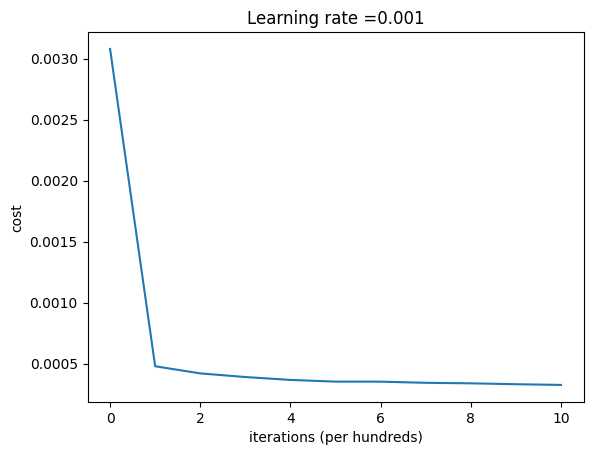

Elapsed time : 533.7415108680725 seconds


In [19]:
layer_dims = [num_pixel*num_pixel,25,15,10]
start = time.time()
parameters = model(x_train,y_train,layer_dims,0.001,1001,0,0.8,512,0.9,0.999,True,False)
end = time.time()
print(f"Elapsed time : {end-start} seconds")

In [20]:
train_accuracy, train_prediction = predict(parameters, x_train, y_train)

In [21]:
print(f"Accuracy on training set : {train_accuracy*100}%")

Accuracy on training set : 98.595%


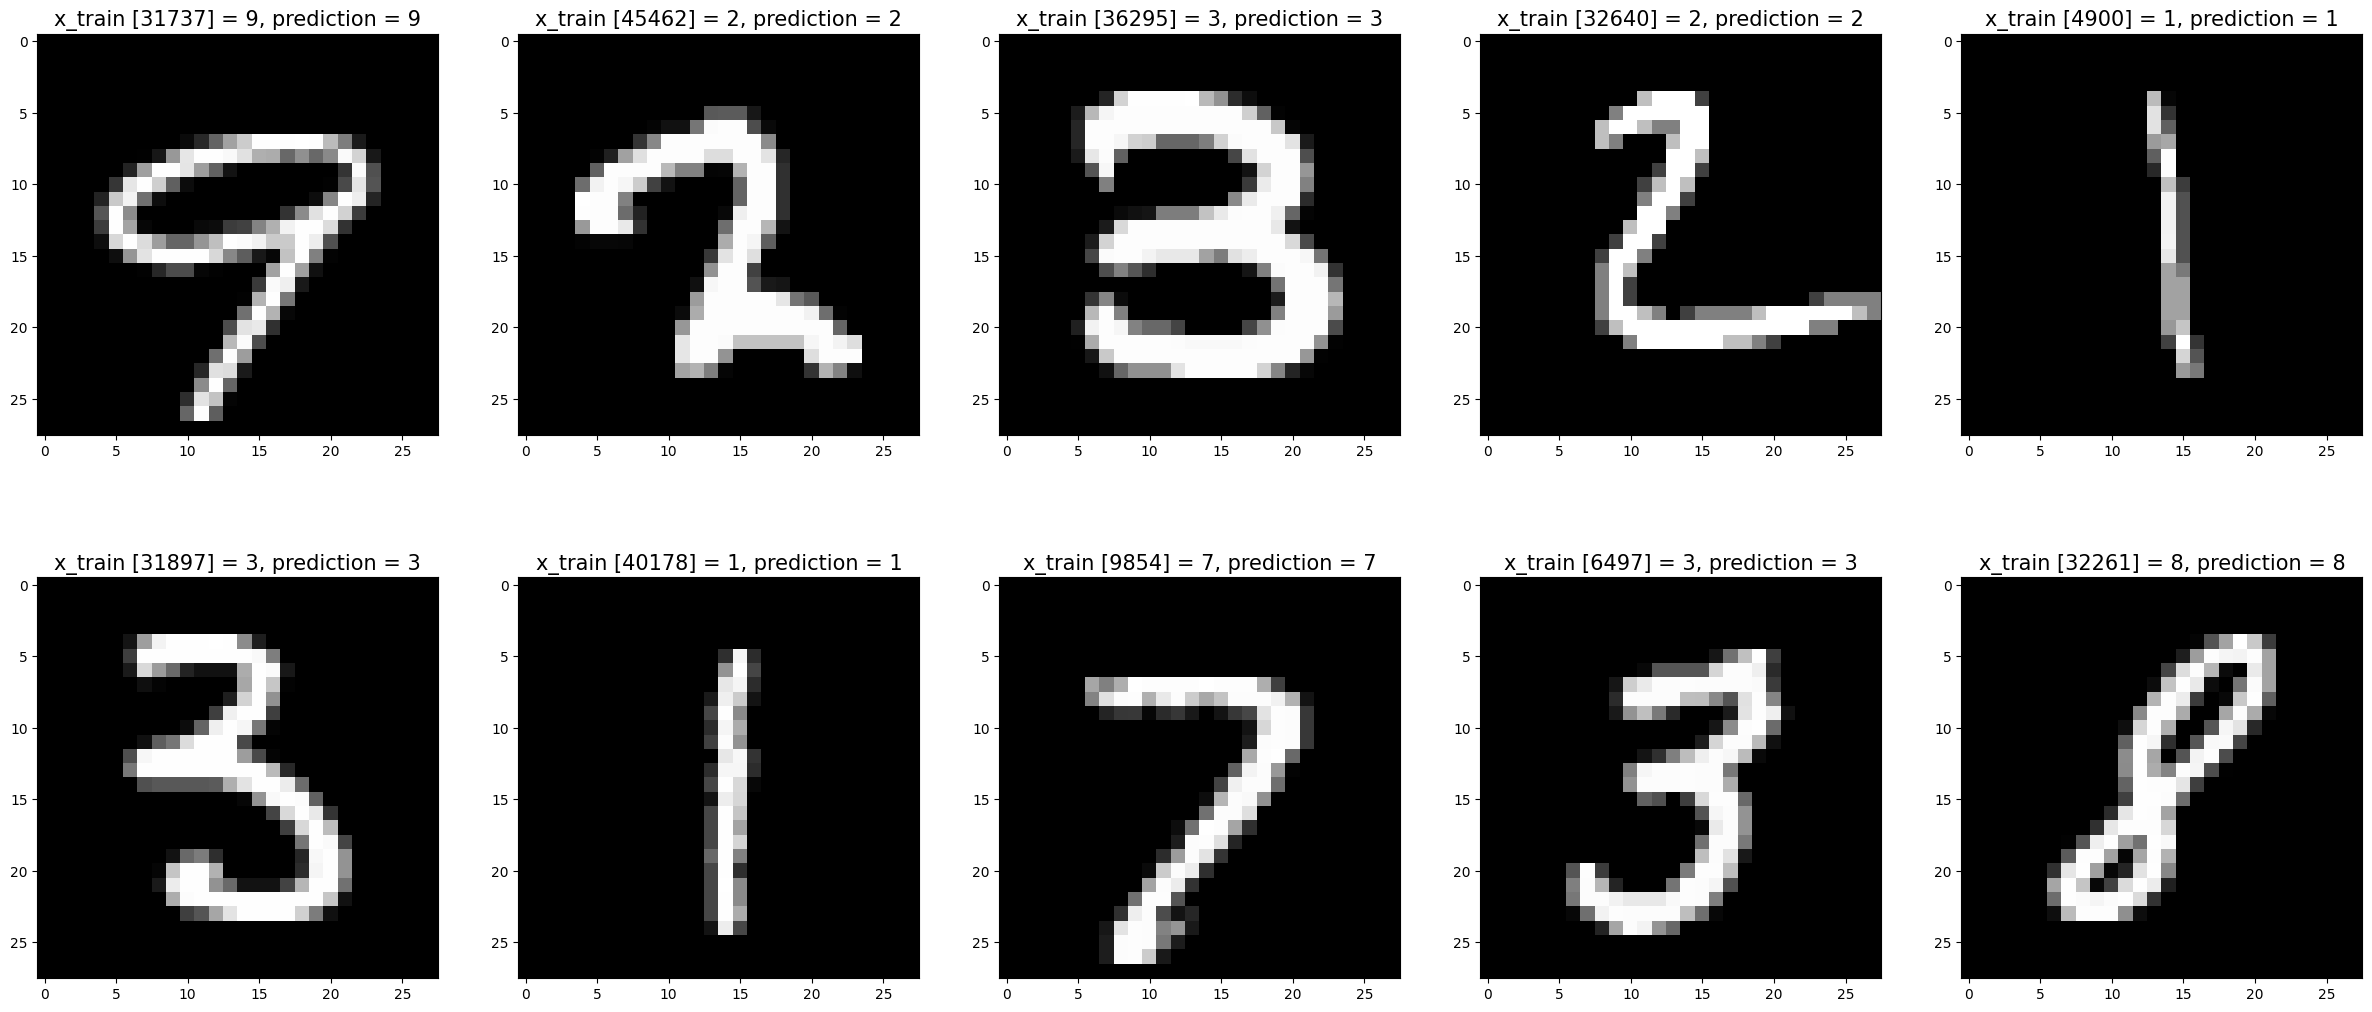

In [22]:
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, m_train)
    images_2_show.append(x_train[:,r].reshape((num_pixel,num_pixel)))
    titles_2_show.append('x_train [' + str(r) + '] = ' + str(y_train[0,r]) + ', prediction = ' + str(train_prediction[r]))    

show_images(images_2_show, titles_2_show)

In [23]:
test_accuracy,test_prediction = predict(parameters,x_test,y_test)

In [24]:
print(f"Accuracy on test set : {test_accuracy*100}%")

Accuracy on test set : 94.71000000000001%


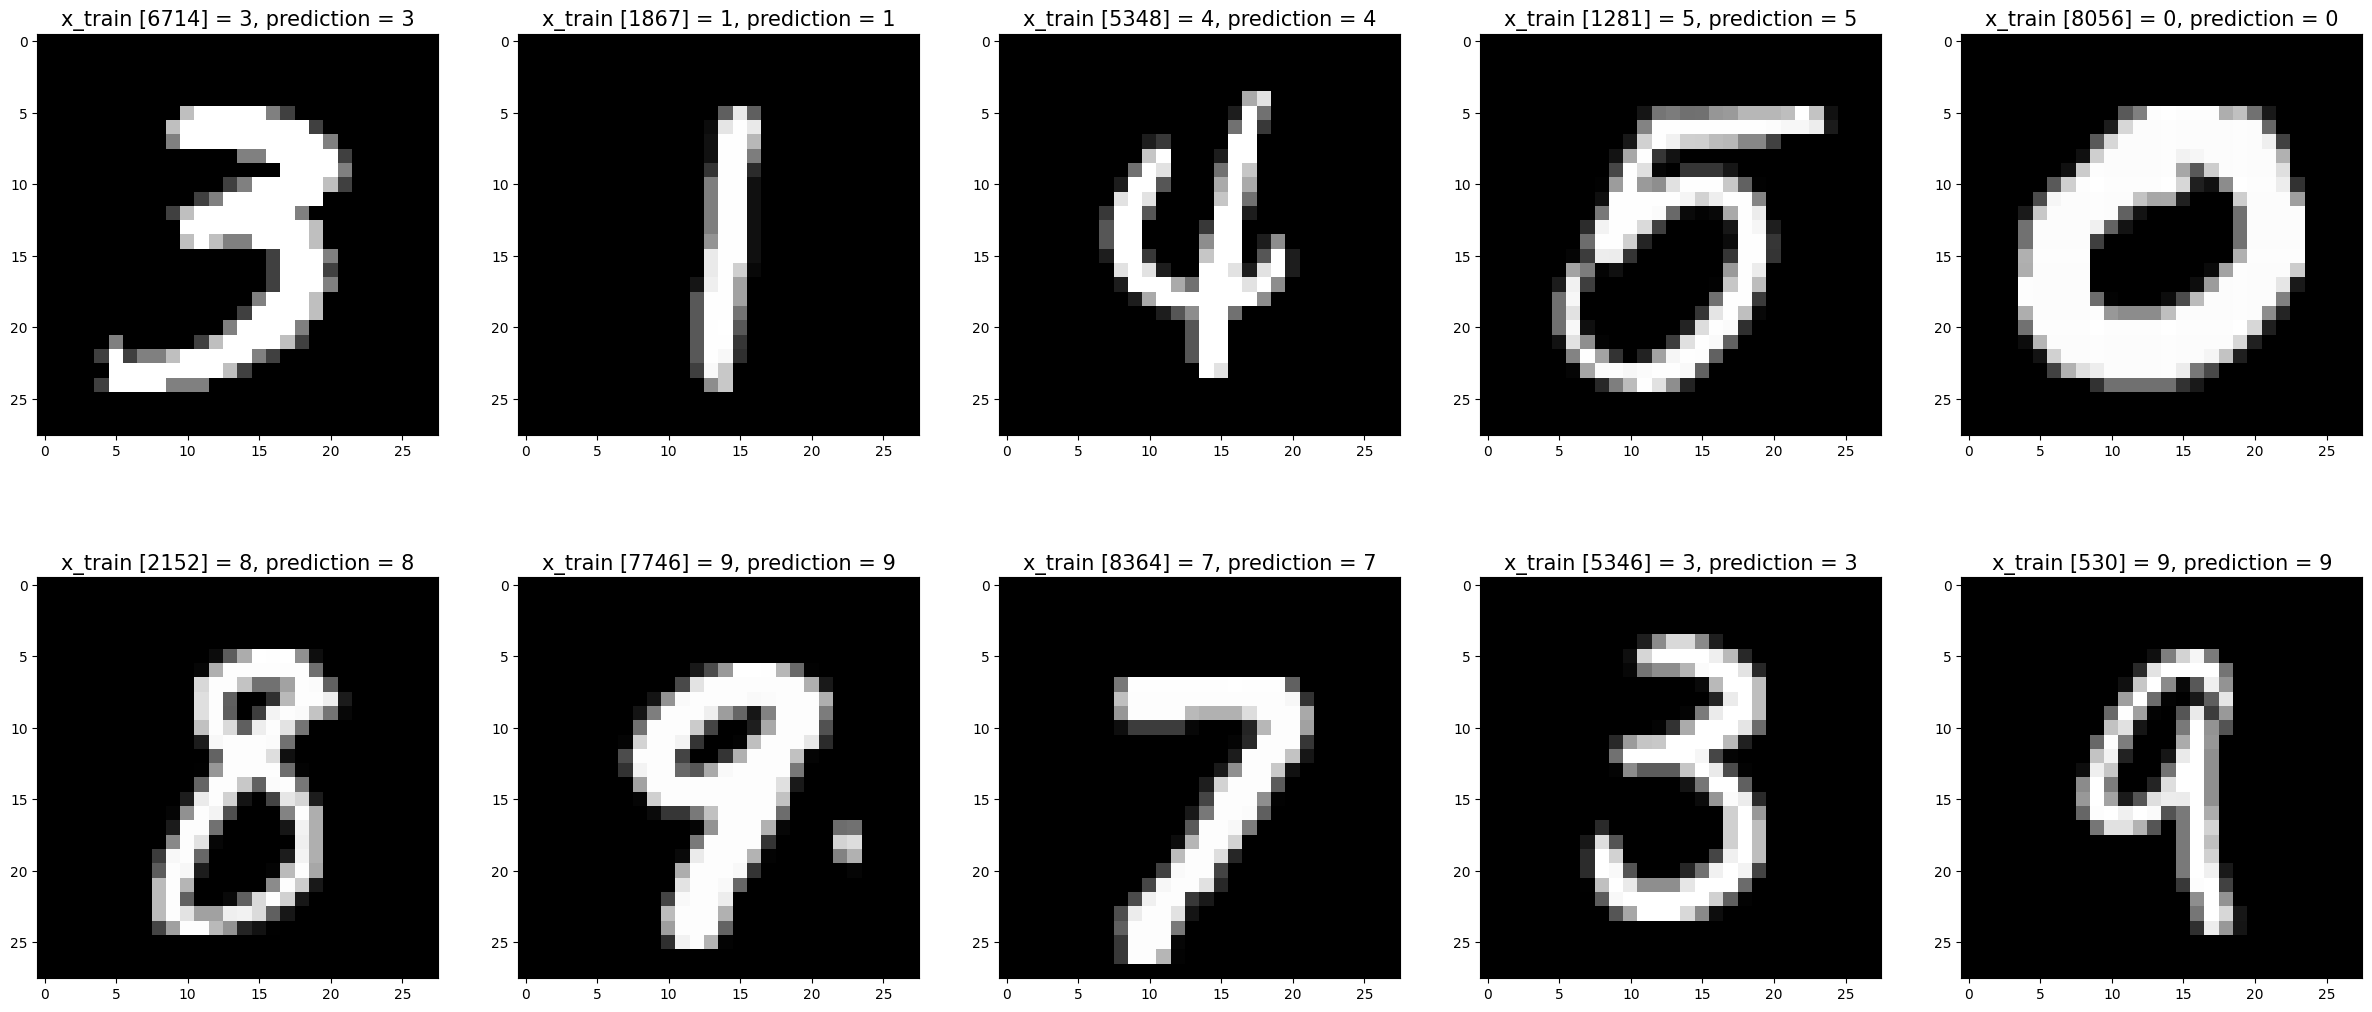

In [25]:
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, m_test)
    images_2_show.append(x_test[:,r].reshape((num_pixel,num_pixel)))
    titles_2_show.append('x_train [' + str(r) + '] = ' + str(y_test[0,r]) + ', prediction = ' + str(test_prediction[r]))    

show_images(images_2_show, titles_2_show)

In [26]:
test_prediction = test_prediction.reshape(y_test.shape)